# modules imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time as time
import tqdm 
import os
from scipy.stats import chisquare

In [2]:
import os
import datetime
Enrich_Path =r"C:\Users\Persona.ly_DS1\Desktop\Technion\Data Processing\1. Data Reading and Enrichments"
os.chdir(Enrich_Path)
from sklearn.cluster import KMeans

In [3]:
%run Reading&Enrichments.ipynb

Reading&Enrichments.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "# Reading the data and adding Enrichments"


In [4]:
Col_Filter = [
                    'crid','uadeviceram','ppi','time','height','bidtime'#,'install'
                    'Impression_Price','bid','impr','installprice','bidtime','Impression_Price',
                    'month','bundleAvgUserRating','uareleaseyear','device_age'
            ]
corr = df[[x for x in df.columns if x not in Col_Filter]].corr()
corr.style.background_gradient(cmap='coolwarm')

,install,uabatterycapacity,ssps,apps,bundletotalfc,Local_day_of_week,normal_apps,normal_ssps,normal_rate,isLandscape,log2ofstorage
install,1,-0.00209074,-0.0195333,-0.00265972,-0.0408842,0.00277454,-0.00265972,-0.0195333,0.0021574,0.00870566,-0.000796633
uabatterycapacity,-0.00209074,1,-0.110214,-0.0386626,0.047096,0.00446871,-0.0386626,-0.110214,-0.0484206,0.0150964,0.0226191
ssps,-0.0195333,-0.110214,1,0.514269,0.100103,0.000634269,0.514269,1,0.0291881,-0.0174431,0.0760816
apps,-0.00265972,-0.0386626,0.514269,1,-0.0147834,0.00079213,1,0.514269,-0.0232559,-0.00121992,0.0284524
bundletotalfc,-0.0408842,0.047096,0.100103,-0.0147834,1,-0.000590892,-0.0147834,0.100103,-0.0385275,0.0133794,0.00846021
Local_day_of_week,0.00277454,0.00446871,0.000634269,0.00079213,-0.000590892,1,0.00079213,0.000634269,-0.000292646,0.0177078,0.00938282
normal_apps,-0.00265972,-0.0386626,0.514269,1,-0.0147834,0.00079213,1,0.514269,-0.0232559,-0.00121992,0.0284524
normal_ssps,-0.0195333,-0.110214,1,0.514269,0.100103,0.000634269,0.514269,1,0.0291881,-0.0174431,0.0760816
normal_rate,0.0021574,-0.0484206,0.0291881,-0.0232559,-0.0385275,-0.000292646,-0.0232559,0.0291881,1,0.115732,-0.055177
isLandscape,0.00870566,0.0150964,-0.0174431,-0.00121992,0.0133794,0.0177078,-0.00121992,-0.0174431,0.115732,1,-0.023711


# Data Exploration

### Checking IInstall Rate per feature

### Device age in years

In [5]:
df['device_age'] = datetime.datetime.now().year - df.uareleaseyear

In [6]:
d_age_min = df.device_age.min()
d_age_max = df.device_age.max()
df['d_age_normalized'] = df.device_age.apply(lambda x: (x-d_age_min)/(d_age_max-d_age_min))

In [7]:
prior_inst_rate = sum(df.install)/ len(df.install)
prior_inst_rate

0.005313822369134262

In [11]:
Prior_ROAS = 100*df.installprice.sum()/df.Impression_Price.sum()

## install rate per normalized device age in years  with prior install rate threshold

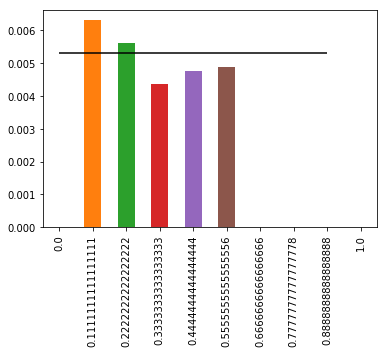

In [8]:
(df[df.install == 1].d_age_normalized.value_counts().sort_index()/df.d_age_normalized.value_counts().sort_index()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 8)

,Impression_Price,installprice,ROAS
d_age_normalized,,,
0.000000,0.293347,0.0,0.000000
0.111111,1180.221835,2120.0,179.627248
0.222222,3260.545676,5420.0,166.229844
0.333333,2267.679961,3125.0,137.806042
0.444444,799.463848,1290.0,161.358141
0.555556,189.780187,320.0,168.616126
0.666667,1.009459,0.0,0.000000
0.777778,4.876070,0.0,0.000000
0.888889,0.060057,0.0,0.000000


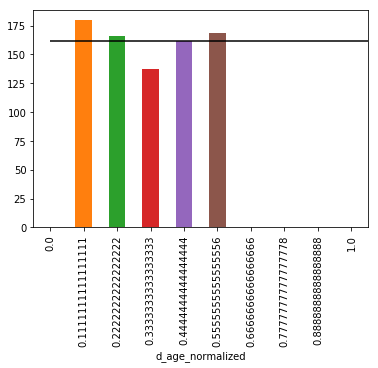

In [13]:
Eval_d_age_norm = df[[
                    'd_age_normalized','Impression_Price','installprice'
                ]].groupby(by='d_age_normalized').sum()

Eval_d_age_norm['ROAS'] = 100*Eval_d_age_norm.installprice / Eval_d_age_norm.Impression_Price

Eval_d_age_norm.ROAS.plot.bar()
plt.hlines(Prior_ROAS,xmin = 0, xmax = 20)
Eval_d_age_norm

## install rate per bundletotalfc feature with prior install rate threshold

In [ ]:
(df[df.install == 1].bundletotalfc.value_counts()/df.bundletotalfc.value_counts()).plot()
plt.hlines(prior_inst_rate,xmin = 1,xmax = 8)

### Oreintation Exploration 

In [ ]:
(df[df.install == 1].isLandscape.value_counts()/df.isLandscape.value_counts()).sort_values().plot.bar()
plt.hlines(prior_inst_rate,xmin =-1,xmax = 8)

In [ ]:
Eval_Landscape = df[[
                    'isLandscape','Impression_Price','installprice'
                ]].groupby(by='isLandscape').sum()

Eval_Landscape['ROAS'] = 100*Eval_Landscape.installprice / Eval_Landscape.Impression_Price

Eval_Landscape.ROAS.plot.bar()
plt.hlines(prior_ROAS,xmin = 0, xmax = 4)
Eval_Landscape

In [ ]:
Eval_Landscape

In [ ]:
df.isLandscape.value_counts()

## Same Main Category. in this case  - Casino

In [15]:
df['cat_is_casino'] = 1*df.bundleCategory.str.contains('casino',na=False)

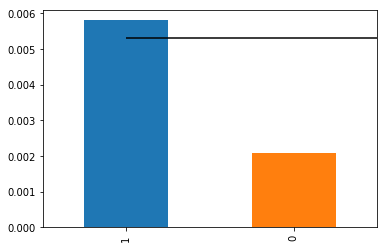

In [16]:
(df[df.install == 1].cat_is_casino.value_counts()/df.cat_is_casino.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 8)

In [17]:
Eval_matrix = df[[
                    'cat_is_casino','Impression_Price','installprice'
                ]].groupby(by='cat_is_casino').sum()

Eval_matrix['ROAS'] = 100*Eval_matrix.installprice / Eval_matrix.Impression_Price

Eval_matrix#.ROAS.plot.bar()
#plt.hlines(prior_ROAS,xmin = 0, xmax = 4)

,Impression_Price,installprice,ROAS
cat_is_casino,,,
0,932.491861,735.0,78.821063
1,8012.976687,13725.0,171.284662


## Taking Care of normalized_apps - normalized_ssps high correlation with clustring into 4 groups using k means


In [ ]:
df.normal_apps = df.normal_apps.fillna('-1')
df.normal_ssps = df.normal_ssps.fillna('-1')

len(df[df.normal_apps == '-1'])
# 2 records of na , discarded

df = df[df.normal_apps != '-1']

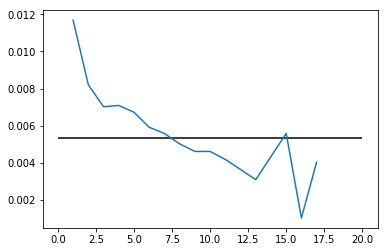

In [35]:
(df[df.install == 1].ssps.value_counts()/df.ssps.value_counts()).plot()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 20)

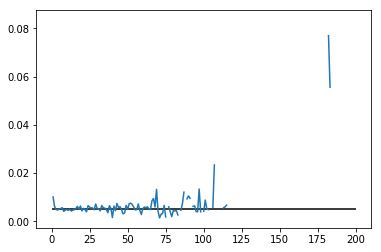

In [37]:
(df[df.install == 1].apps.value_counts()/df.apps.value_counts()).plot()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 200)

In [38]:
df.apps.value_counts()

5.0      26974
4.0      26764
6.0      25701
7.0      25033
3.0      25006
8.0      24896
9.0      23022
1.0      22054
10.0     21788
2.0      21143
11.0     20124
12.0     18068
13.0     16838
14.0     16054
15.0     14536
16.0     13107
17.0     12386
18.0     10934
19.0     10198
20.0      9549
21.0      8672
22.0      8476
23.0      7559
24.0      6750
25.0      6399
26.0      6125
27.0      5745
28.0      5198
29.0      4880
30.0      4516
         ...  
320.0        1
597.0        1
312.0        1
331.0        1
421.0        1
710.0        1
340.0        1
275.0        1
330.0        1
704.0        1
259.0        1
414.0        1
642.0        1
258.0        1
329.0        1
442.0        1
308.0        1
364.0        1
443.0        1
327.0        1
349.0        1
251.0        1
614.0        1
449.0        1
416.0        1
606.0        1
284.0        1
249.0        1
701.0        1
313.0        1
Name: apps, Length: 378, dtype: int64

## Exploration of crids - creative data that is shown to the user.

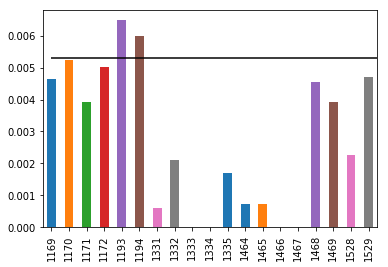

In [39]:
(df[df.install ==1].crid.value_counts()/df.crid.value_counts()).plot.bar()
plt.hlines(prior_inst_rate,xmin = 0,xmax = 20)

In [40]:
crids = df[['crid','Impression_Price','installprice']].groupby('crid').sum()
crids['ROAS'] = 100*crids.installprice/crids.Impression_Price

In [41]:
#Creating a threshold of aggregated amount of spend of 180$
crids= crids[crids.Impression_Price > 180]
crids

,Impression_Price,installprice,ROAS
crid,,,
1169,2067.436909,3000.0,145.107209
1170,1242.925590,1990.0,160.106125
1171,499.429231,620.0,124.141712
1193,2241.071788,4295.0,191.649372
1194,2123.986538,3600.0,169.492600
1468,209.284184,300.0,143.345758
1469,215.169498,270.0,125.482470


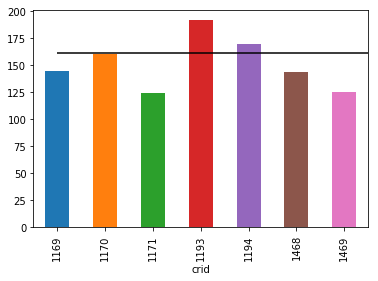

In [43]:
crids.ROAS.plot.bar()
plt.hlines(Prior_ROAS,xmin = 0, xmax = 20)

### SiteName Engineering of words

In [44]:
df.sitename.head(10)

0                       Zombie Ghosts Coin Party Dozer
1    Slots! CashHit Slot Machines & Casino Games Party
2    Cashmania Slots 2019: Free Vegas Casino Slot G...
3                   GSN Casino - Mediation (no blocks)
4           Lucky CASH Slots - Win Real Money & Prizes
5                                           Free Slots
6              Cleopatra Slots Fortunes of Luxor Egypt
7           Lucky CASH Slots - Win Real Money & Prizes
8     Viva Slots Vegas™ Free Slot Jackpot Casino Games
9        Royal Slots Free Slot Machines & Casino Games
Name: sitename, dtype: object

In [45]:
set_aside = set(df.sitename)
set_aside = list(set_aside)
set_aside2= []
for i in set_aside:
    if type(i) == str:
        set_aside2 = set_aside2 + i.split()

In [46]:
set_aside = pd.DataFrame(set_aside2)[0].value_counts().reset_index().rename(columns = {"index":'word',0:'Count'})
set_aside = set_aside[set_aside.word.astype(str).str.contains('[A-Za-z]')]

### get 7 top words in site name description 

In [47]:
global top7
top7 = set_aside.word.head(7).tolist()

In [48]:
def isin7(x):
    if type(x) == float:
        return np.nan
    elif (set(x.split()) & set(top7)) == set():
        return 0
    return 1

In [49]:
df['isintop6words'] = df.sitename.apply(isin7)

### checking the amount of times the user was seen in different apps in the same category

In [ ]:
df[df.install==1].isintop6words.value_counts()/df.isintop6words.value_counts()

In [59]:
df[df.install==1].cat_is_casino.value_counts()/df.cat_is_casino.value_counts()

1    0.005798
0    0.002048
Name: cat_is_casino, dtype: float64